In [12]:
import pandas as pd
import numpy as np
import zipfile

zip_file_path = r"C:\Users\win 10\Downloads\diabetes+130-us+hospitals+for+years+1999-2008.zip"

# Open ZIP and read CSV
with zipfile.ZipFile(zip_file_path, 'r') as z:
    print("Files in ZIP:", z.namelist())
    csv_file = 'diabetic_data.csv'
    df = pd.read_csv(z.open(csv_file))

print("Dataset Shape:", df.shape)
print("\nSample Data:")
print(df.head())

# Replace '?' with NaN
df.replace("?", np.nan, inplace=True)

# Missing values per column
missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:\n", missing[missing>0])


Files in ZIP: ['diabetic_data.csv', 'IDS_mapping.csv']
Dataset Shape: (101766, 50)

Sample Data:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton 

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# ----------------------
# Identify categorical and numeric columns
# ----------------------
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

# Fill categorical missing values
for col in cat_cols:
    df[col] = df[col].fillna("Unknown")

# Encode target variable
df['readmitted_label'] = df['readmitted'].map({'NO':0, '>30':0, '<30':1})

# ----------------------
# ColumnTransformer for numeric + categorical columns
# ----------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [c for c in cat_cols if c != 'readmitted']),
        ('num', SimpleImputer(strategy='median'), num_cols)
    ]
)

# Transform features
X_encoded = preprocessor.fit_transform(df.drop(columns=['readmitted','readmitted_label']))
y = df['readmitted_label']

# Feature names
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()
all_feature_names = list(ohe_feature_names) + num_cols

# Convert to DataFrame for visualization
X_encoded_df = pd.DataFrame(X_encoded, columns=all_feature_names)

print("Sample encoded features:")
print(X_encoded_df.head())
print("\nTarget distribution:")
print(y.value_counts())

# ----------------------
# Feature Importance using RandomForest
# ----------------------
rf_fs = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)
rf_fs.fit(X_encoded, y)

importances = pd.Series(rf_fs.feature_importances_, index=all_feature_names).sort_values(ascending=False)
print("\nTop 20 features by importance:")
print(importances.head(20))

# Select top 30 features
top_features = importances.head(30).index.tolist()
print(top_features)

Sample encoded features:
   race_AfricanAmerican  race_Asian  race_Caucasian  race_Hispanic  \
0                   0.0         0.0             1.0            0.0   
1                   0.0         0.0             1.0            0.0   
2                   1.0         0.0             0.0            0.0   
3                   0.0         0.0             1.0            0.0   
4                   0.0         0.0             1.0            0.0   

   race_Other  race_Unknown  gender_Female  gender_Male  \
0         0.0           0.0            1.0          0.0   
1         0.0           0.0            1.0          0.0   
2         0.0           0.0            1.0          0.0   
3         0.0           0.0            0.0          1.0   
4         0.0           0.0            0.0          1.0   

   gender_Unknown/Invalid  age_[0-10)  ...  discharge_disposition_id  \
0                     0.0         1.0  ...                      25.0   
1                     0.0         0.0  ...             

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Keep only top features
top_indices = [all_feature_names.index(f) for f in top_features]
X_train_top = X_train[:, top_indices]
X_test_top = X_test[:, top_indices]

print("Shape of X_train_top:", X_train_top.shape)
print("Shape of X_test_top:", X_test_top.shape)

Shape of X_train_top: (81412, 30)
Shape of X_test_top: (20354, 30)


In [5]:
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=0, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0),
    "LinearSVM": CalibratedClassifierCV(LinearSVC(max_iter=5000, random_state=0), cv=3)
}

trained_models = {}
for name, clf in models.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train_top, y_train)
    trained_models[name] = clf



Training RandomForest...

Training XGBoost...


c:\Users\win 10\Desktop\Diabetic dataset\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training LinearSVM...


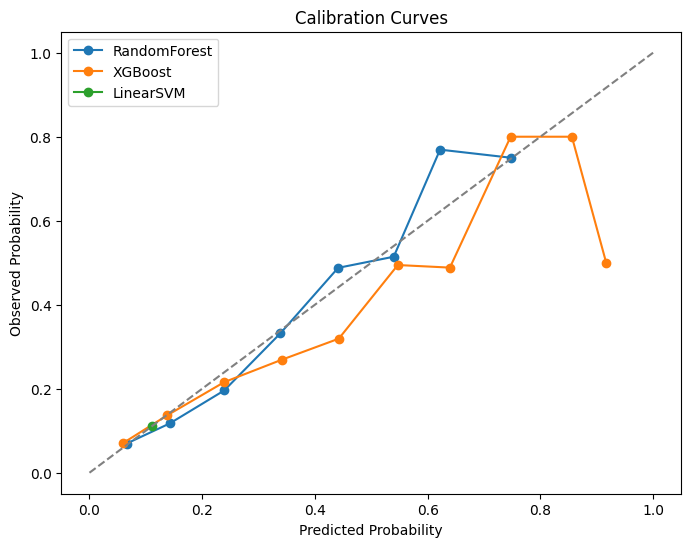


Model Performance:
{'RandomForest': {'ROC-AUC': 0.6542969227978634, 'Brier': 0.0951399719410872}, 'XGBoost': {'ROC-AUC': 0.6694352376279123, 'Brier': 0.0947352310614925}, 'LinearSVM': {'ROC-AUC': 0.49271175895151315, 'Brier': 0.09913318388642774}}


In [6]:
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
results = {}

for name, clf in trained_models.items():
    y_proba = clf.predict_proba(X_test_top)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    brier = brier_score_loss(y_test, y_proba)
    results[name] = {"ROC-AUC": auc, "Brier": brier}
    
    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Probability")
plt.title("Calibration Curves")
plt.legend()
plt.show()

print("\nModel Performance:")
print(results)


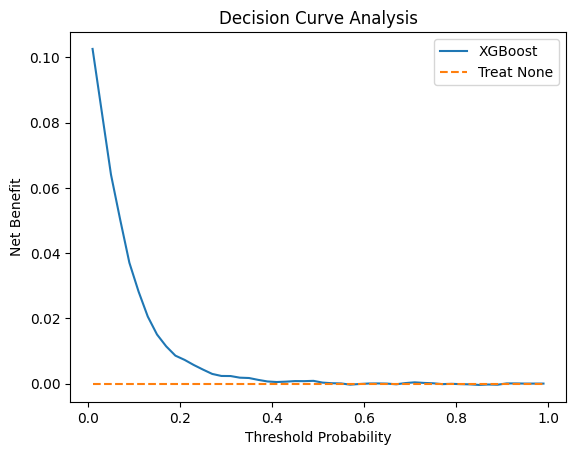

In [7]:
def decision_curve(y_true, prob, thresholds=np.linspace(0.01,0.99,50)):
    N = len(y_true)
    net_benefits = []
    for pt in thresholds:
        preds = (prob >= pt).astype(int)
        TP = ((preds==1) & (y_true==1)).sum()
        FP = ((preds==1) & (y_true==0)).sum()
        nb = TP/N - FP/N * (pt/(1-pt))
        net_benefits.append(nb)
    return thresholds, np.array(net_benefits)

best_model_name = "XGBoost"
best_model = trained_models[best_model_name]
y_proba = best_model.predict_proba(X_test_top)[:,1]

thr, nb = decision_curve(y_test, y_proba)
plt.plot(thr, nb, label=best_model_name)
plt.plot(thr, np.zeros_like(thr), linestyle='--', label='Treat None')
plt.xlabel('Threshold Probability')
plt.ylabel('Net Benefit')
plt.title('Decision Curve Analysis')
plt.legend()
plt.show()


c:\Users\win 10\Desktop\Diabetic dataset\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


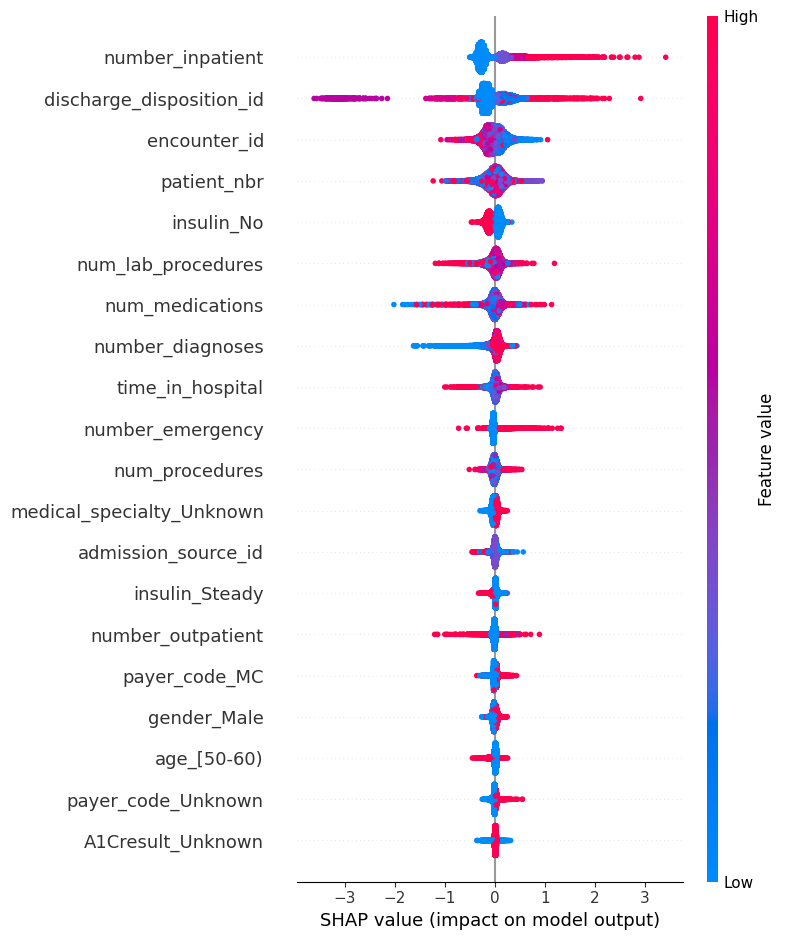

In [8]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_top)

shap.summary_plot(shap_values, X_test_top, feature_names=top_features)


In [9]:
import joblib
joblib.dump(best_model, "xgboost_readmission_model.joblib")
print("Model saved successfully!")


Model saved successfully!
